# Manual Feature Creation and Selection

In [1235]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedShuffleSplit

In [1300]:
training = pd.read_csv('./datasets/training_experimental.csv', index_col=0)
test = pd.read_csv('./datasets/test_experimental.csv', index_col=0)

In [1301]:
training['total_bath'] = training['bsmt_full_bath'] + \
                         0.5 * training['bsmt_half_bath'] + \
                         training['full_bath'] + \
                         0.5 * training['half_bath']

test['total_bath'] = test['bsmt_full_bath'] + \
                         0.5 * test['bsmt_half_bath'] + \
                         training['full_bath'] + \
                         0.5 * test['half_bath']


In [1303]:
training['all_sf'] = training['gr_liv_area'] + training['total_bsmt_sf']
training['all_flr_sf'] = training['1st_flr_sf'] + training['2nd_flr_sf']

test['all_sf'] = test['gr_liv_area'] + test['total_bsmt_sf']
test['all_flr_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']

In [1304]:
training['pool'] = training['pool_qc'].apply(lambda x: 0 if x == 'none' else 1)

In [1305]:
training['garage_ratio'] = training['garage_cars'] / training['garage_area']

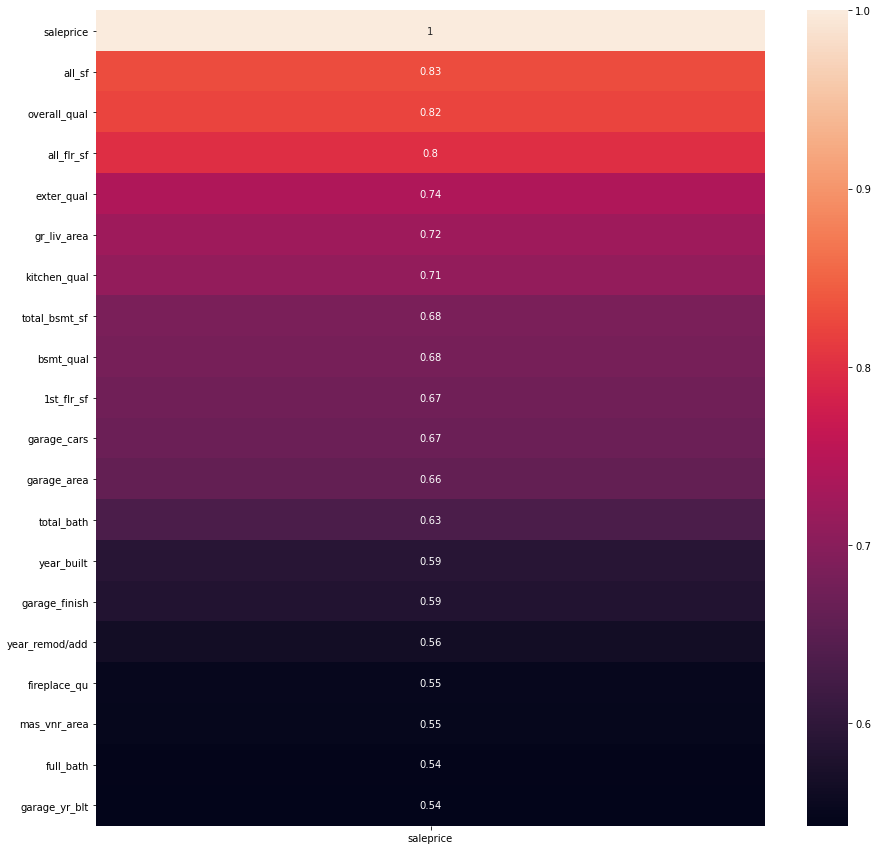

In [1306]:
plt.figure(figsize=(15, 15))
sns.heatmap(training.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).head(20), annot=True);

In [1307]:
training.shape

(1686, 89)

In [1308]:
test.shape

(876, 86)

In [1311]:
X = training.drop('saleprice', axis=1)

In [1312]:
y = training['saleprice']

In [1313]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [1317]:
X_train = pd.get_dummies(X_train)
test = pd.get_dummies(test)

## Linear Regression Pipeline and Gridsearch

In [1322]:
lr_pipe = make_pipeline(StandardScaler(), 
                        #PolynomialFeatures(), 
                        RFE(LinearRegression()), 
                        LinearRegression())


In [1323]:
lr_params = {
    #'rfe__n_features_to_select': range(100, 250),
    'linearregression__fit_intercept': [True, False],
          }

In [1324]:
lr_gs = GridSearchCV(lr_pipe, lr_params, n_jobs=-1)

In [1325]:
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('rfe',
                                        RFE(estimator=LinearRegression())),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False]})

In [1326]:
# Scoring the model

print('Linear Regression Test Score', lr_gs.score(X_test, y_test))
print('Linear Regression RMSE Test', mean_squared_error(y_test, lr_gs.predict(X_test), squared=False))
print('Linear Regression Training Score', lr_gs.score(X_train, y_train))
print('Linear Regression RMSE Training', mean_squared_error(y_train, lr_gs.predict(X_train), squared=False))

preds = lr_gs.predict(X_test)
resids = np.array(y_test) - preds
sns.scatterplot(x=y_test, y=resids)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline();

ValueError: could not convert string to float: 'RL'

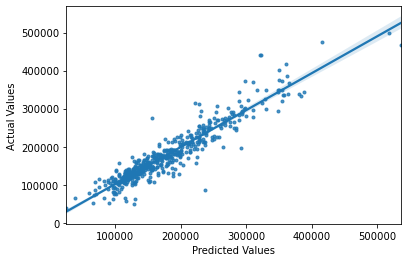

In [1050]:
sns.regplot(x=preds, y=y_test, marker='.')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

In [1051]:
# Calculating best parameters
lr_gs.best_params_

{'linearregression__fit_intercept': False, 'rfe__n_features_to_select': 133}

In [1052]:
# Creating predictions CSV
test_preds = lr_gs.predict(test)
test1 = pd.read_csv('./test.csv')
submission= pd.DataFrame(test_preds, index=test1['Id'])
submission.columns = ['saleprice']

In [1053]:
#Exporting predictions CSV
#submission.to_csv('./datasets/1_lr_submission.csv')

## Ridge Regression Pipeline and Gridsearch

In [1114]:
ridge_pipe = make_pipeline(
    StandardScaler(), 
    PolynomialFeatures(), 
    SelectKBest(f_regression), 
    Ridge())


In [1115]:
ridge_params = {
    'selectkbest__k': range(50, 150),
    'ridge__fit_intercept': [True, False],
    'ridge__alpha': range(50, 200, 10)
          }

In [1116]:
ridge_gs = GridSearchCV(ridge_pipe, ridge_params, n_jobs=-1)

In [1117]:
ridge_gs.fit(X_train, y_train)

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fce32648f80>)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': range(50, 200, 10),
                         'ridge__fit_intercept': [True, False],
                         'selectkbest__k': range(50, 150)})

Ridge Test Score 0.9048261274548386
Ridge RMSE Test 24001.529953673966
Ridge Training Score 0.9235252064142446
Ridge RMSE Training 20092.274989502796


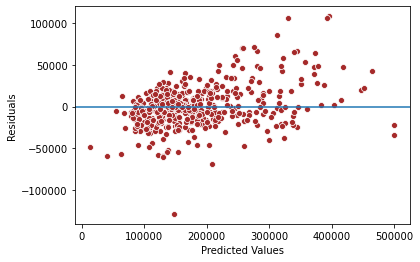

In [1118]:
# Scoring the model

print('Ridge Test Score', ridge_gs.score(X_test, y_test))
print('Ridge RMSE Test', mean_squared_error(y_test, ridge_gs.predict(X_test), squared=False))
print('Ridge Training Score', ridge_gs.score(X_train, y_train))
print('Ridge RMSE Training', mean_squared_error(y_train, ridge_gs.predict(X_train), squared=False))

preds = ridge_gs.predict(X_test)
resids = np.array(y_test) - preds
sns.scatterplot(x=y_test, y=resids, color='brown')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline();

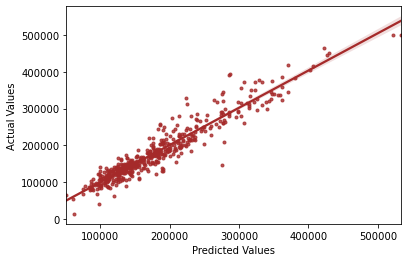

In [1119]:
sns.regplot(x=preds, y=y_test, marker='.', color='brown')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

In [1120]:
# Calculating best parameters
ridge_gs.best_params_

{'ridge__alpha': 90, 'ridge__fit_intercept': True, 'selectkbest__k': 72}

In [1121]:
# Creating predictions CSV
test_preds = ridge_gs.predict(test)
test1 = pd.read_csv('./test.csv')
submission= pd.DataFrame(test_preds, index=test1['Id'])
submission.columns = ['saleprice']

In [1122]:
#Exporting predictions CSV
#submission.to_csv('./2_ridge_submission.csv')

## Lasso Regression Pipeline and Gridsearch

(1264, 264)